In [10]:
# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# [[논문 구현] PyTorch로 LeNet-5(1998) 구현하기](https://deep-learning-study.tistory.com/503?category=983681)
- success

## CUDA check
- 사용가능한 GPU 확인하기

In [1]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cpu


## MNIST dataset load

In [4]:
# 1. MNIST dataset load
from torchvision import datasets

path2data = './data'
train_data = datasets.MNIST(path2data, train = True, download = True, transform = data_transform)
val_data = datasets.MNIST(path2data, train = False, download = True, transform = data_transform)

# 2. MNIST dataset에 적용할 transformation 객체 생성
from torchvision import transforms
data_transform = transforms.Compose([transforms.Resize((32, 32)),
                                     transforms.ToTensor(),
                                    ])

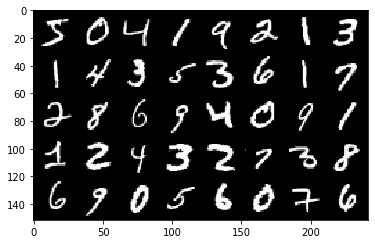

In [32]:
# 3. sample images 확인
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# train_data에서 x, y 추출
x_train, y_train = train_data.data, train_data.targets

# val_data에서 x, y 추출
x_val, y_val = val_data.data, val_data.targets

# 차원을 추가하여 B * C * H * W 가 되도록 함
# 3차원의 경우 B * H * W 였음
if len(x_train.shape) == 3:
    x_train = x_train.unsqueeze(1) 

if len(x_val.shape) == 3:
    x_val = x_val.unsqueeze(1)

# colormap 색상 바꿔보기 -> 반영이 안되네..?
import matplotlib.cm as cm
    
# tensor to image function
def show(tensor):
    
    # tensor to np.array
    array = tensor.numpy()
    
    # C * H * W -> H * W * C
    array_trans = array.transpose((1, 2, 0))
    
    # interpolation : 보간법을 뜻하며, 픽셀들의 축 위치 간격을 보정하여 이미지가 자연스러운 모양으로 보일 수 있게 함
    # 총 16가지의 보간법이 있는데 그 중 'nearest'는 가장 고해상도인 보간법임
    plt.imshow(array_trans, interpolation = 'nearest', cmap = cm.Blues) 

# images grid를 생성하고 출력하기
# 총 40개의 이미지, 행당 8개 이미지를 출력함
x_grid = utils.make_grid(x_train[:40], nrow = 8, padding=2)

show(x_grid)

In [102]:
# 4. dataloader 생성하기
from torch.utils.data import DataLoader

train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
val_dl = DataLoader(val_data, batch_size=32)

## LeNet-5 modeling

In [47]:
from torch import nn
import torch.nn.functional as F

class LeNet_5(nn.Module):
    
    # subsampling(pooling) 계층은 여기서 구현 안하네
    # forward에서 구현하는 듯
    def __init__(self):
        super(LeNet_5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.tanh(self.conv1(x)) # C1
        x = F.avg_pool2d(x, 2, 2) # S2 / (x, kernel_h, kernel_w)
        x = F.tanh(self.conv2(x)) # C3
        x = F.avg_pool2d(x, 2, 2) # S4
        x = F.tanh(self.conv3(x)) # C5
        print(x.shape)
        x = x.view(-1, 120) 
        print(x.shape)
        x = F.tanh(self.fc1(x)) # F6
        x = self.fc2(x) # F7
        print(x.shape)
        return F.softmax(x, dim=1)
        print(x.shape)

model = LeNet_5()
print(model)

LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [48]:
# 모델을 cuda or cpu로 전달하기
model.to(device)
print(next(model.parameters()).device)

LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

cpu


In [49]:
# 모델 summary 확인하기
from torchsummary import summary
summary(model, input_size=(1, 32, 32))

torch.Size([2, 120, 1, 1])
torch.Size([2, 120])
torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Conv2d-3            [-1, 120, 1, 1]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


## loss function, optimizer 정의하기

In [51]:
# 1. loss function 정의하기
loss_func = nn.CrossEntropyLoss(reduction='sum')

# 2. optimizer 정의하기
from torch import optim
opt = optim.Adam(model.parameters(), lr=0.001)

# 3. 현재 learning rate를 계산하는 함수 정의
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
    
# 4. learning rate scheduler 정의
from torch.optim.lr_scheduler import CosineAnnealingLR
lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-05)

## 학습을 위한 함수 정의

In [112]:
'''⭐️output.argmax(dim=1, keepdim=True)'''
a = torch.Tensor([[1,2,3,4,5],
             [2,3,4,5,6],
             [10,10,11,10,10]])
# np.argmax(a,axis=1)
a.argmax(dim=1, keepdim=False)
pred = a.argmax(dim=1, keepdim=True)
pred
# a.argmax(dim=1, keepdim=False)

'''⭐️target.view_as(pred)'''
# view_as() 함수는 target 텐서를 view_as() 함수 안에 들어가는 인수(pred)의 모양대로 다시 정렬
target = torch.Tensor([4, 3, 2])
target.view_as(pred)

pred.eq(target) # 계산이 틀리게 됨
pred.eq(target.view_as(pred)) # shape을 맞춰줘야 계산이 맞음
pred.eq(target.view_as(pred)).sum().item() # boolean -> int로 형변환 후 sum 계산

'''⭐️for xb, yb in dataset_dl:'''
from torch.utils.data import DataLoader

train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
for x, y in train_dl:
    print(x.shape) # (b, c, h, w)
    print(x.ndim)
    print(y.shape) # (b)
    print(y.ndim)
    break

'⭐️output.argmax(dim=1, keepdim=True)'

tensor([4, 4, 2])

tensor([[4],
        [4],
        [2]])

'⭐️target.view_as(pred)'

tensor([[4.],
        [3.],
        [2.]])

tensor([[ True, False, False],
        [ True, False, False],
        [False, False,  True]])

tensor([[ True],
        [False],
        [ True]])

2

'⭐️for xb, yb in dataset_dl:'

torch.Size([32, 1, 32, 32])
4
torch.Size([32])
1


In [79]:
# 1. batch당 performance metric을 계산하는 함수 정의
# output = 10개의 softmax 확률로 구성된 torch.Tensor일 듯
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True) 
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects # pred == target의 개수 (정답을 맞춘 개수)

# 2. batch당 loss를 계산하는 함수 정의
def loss_batch(loss_func, output, target, opt=None):
    loss = lossfunc(output, target)
    corrects = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), corrects # 손실 함수 값, 정답 개수

# 3. epoch당 loss와 performance metric을 계산하는 함수 정의
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_corrects = 0.0
    len_data = len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        
        # GPU 이용하기 위함
        # 모든 입력에 .to(torch.device('cuda')) 함수를 호출해야 모델에 데이터를 제공할 수 있음
        # https://tutorials.pytorch.kr/recipes/recipes/save_load_across_devices.html
        xb = xb.type(torch.float).to(device) # x
        yb = yb.to(device) # y(target)
        output = model(xb)
        loss_b, corrects_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        # 정답을 맞춘 개수가 존재한다면 한 epoch내에서 batch_size마다 맞춘 개수를 더해줌
        if corrects_b is not None:
            running_corrects += corrects_b
        
        # sanity_check가 True이면 1epoch만 학습함
        if sanity_check is True:
            break
    
    loss = running_loss / float(len_data) # 1epoch내(모든 dataset의 길이에 대한) 손실 함수 값의 평균
    corrects = running_corrects / float(len_data) # 1epoch내(모든 dataset의 길이에 대한) 정답인 비율 계산
    return loss, corrects

In [113]:
# 4. train_val 함수 정의 
def train_val(model, params):
    
    # params from where?
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    opt = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']
    
    loss_history = {'train':[], 'val':[]}
    corrects_history = {'train':[], 'val':[]}
    
    # best model parameter 저장하기
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf') # 양의 무한대
    
    for epoch in range(num_epochs):
        current_lr = get_lr(opt) # 앞서 get_lr 정의함
        print(f'Epoch {epoch}/{num_epochs-1}, current lr={current_lr}')
        
        # 학습 후 loss, corrects 구해서 loss_history, corrects_history list에 각각 append
        model.train() # ???
        train_loss, train_corrects = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        corrects_history['train'].append(train_corrects)
        
        # 학습이 잘 되었는지 validation dataset으로 test (학습이 아닌 test이므로 최적화가 필요없음)
        model.eval() # ???
        with torch.no_grad(): # 가중치 초기화 하면서 진행
            val_loss, val_corrects = loss_epoch(model, loss_func, train_dl, sanity_check)
            loss_history['val'].append(val_loss)
            corrects_history['val'].append(val_corrects)
        
        # val_loss가 가장 낮을 때의 모델 weights를 찾기 위한 과정
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights')
        
        lr_scheduler.step()
        
        print('train_loss: %.6f, val_loss: %.6f, accuracy: %.2f' %(train_loss, val_loss, 100*val_corrects))
        print('-'*10)
    
    # best model을 반환하기
    model.load_state_dict(best_model_wts)
    return model, loss_history, corrects_history

## 모델 학습하기

In [ ]:
import copy
import os

# 학습된 모델의 가중치를 저장할 폴더 생성
os.makedirs('./models', exist_ok=True)